<a href="https://colab.research.google.com/github/ApoorvaNagarajan/Image-Filter-Kernels/blob/master/assignment9/assignment9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import all the required python libraries

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import load_model

Using TensorFlow backend.


In [2]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from keras.datasets import cifar10

# downloads the CIFAR10 dataset and splits it into test and train.
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()


# calculate the dimensions and number of classes
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


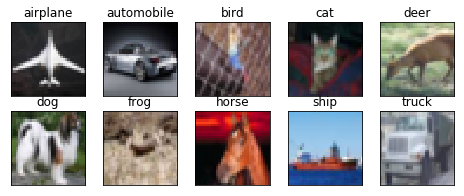

In [4]:
# gallery to display 1 image from each of the classes

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# function to plot loss and accuracy of the network

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
#pixel normalization of test and train data
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [25]:
# Load assignment 6A model

model = load_model("/content/drive/My Drive/models/assign6a_model");
model.summary()
preds = model.predict(test_features)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 128)       0         
__________

In [0]:
def gradCam(pred, x, model, layer):
  class_idx = np.argmax(pred)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (32,32))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  img = np.uint8(255 * x.reshape(32,32,3))
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  return(img,superimposed_img)
  

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [10]:
# Add cutout and train the model again

modelNew = Sequential()

modelNew.add(Convolution2D(64, 3, 3, border_mode='same', input_shape=(32,32,3))) # RF: 3x3, output dim: 32x32x48
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(128, 3, 3, border_mode='same')) # RF: 5x5, output dim: 32x32x48
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(256, 3, 3)) # RF: 7x7, output dim: 30x30x48
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(64, 1, 1, activation='relu')) # RF: 7x7, output dim: 30x30x64
modelNew.add(MaxPooling2D(pool_size=(2, 2))) # RF: 14x14, output dim: 15x15x96
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(64, 3, 3, border_mode='same')) # RF: 16x16, output dim: 15x15x64
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(128, 3, 3, border_mode='same')) # RF: 18x18, output dim: 15x15x128
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(256, 3, 3)) # RF: 20x20, output dim: 13x13x256
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(64, 1, 1, activation='relu')) # RF: 20x20, output dim: 13x13x64
modelNew.add(MaxPooling2D(pool_size=(2, 2))) # RF: 40x40, output dim: 6x6x64
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(64, 3, 3, border_mode='same')) # RF: 42x42, output dim: 6x6x64
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(128, 3, 3, border_mode='same')) # RF: 44x44, output dim: 6x6x128
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))
modelNew.add(Dropout(0.15))

modelNew.add(Convolution2D(256, 3, 3)) # RF: 46x46, output dim: 4x4x256
modelNew.add(BatchNormalization())
modelNew.add(Activation('relu'))


modelNew.add(Convolution2D(num_classes, 1, 1, activation='relu')) # RF: 46x46, output dim: 4x4x10
modelNew.add(Convolution2D(num_classes, 4, 4))


modelNew.add(Flatten())
modelNew.add(Activation('softmax'))


modelNew.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to th

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 128)       0         
__________

In [11]:
# Compile the model
modelNew.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))



# saves the model weights after each epoch if the validation loss decreased
checkpoint = ModelCheckpoint("assign9_cutout",verbose=1,save_best_only=True, monitor='val_acc', mode='max')



model_info = modelNew.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = len(train_features), nb_epoch = 50, 
                                # validation_data = datagen.flow(test_features, test_labels),validation_steps=len(test_features)/32,
                                 validation_data = (test_features, test_labels),
                                 callbacks=[checkpoint], verbose=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50
390/390 [==============================] - 54s 137ms/step - loss: 1.6093 - acc: 0.4036 - val_loss: 1.7016 - val_acc: 0.4203

Epoch 00001: val_acc improved from -inf to 0.42030, saving model to assign9_cutout
Epoch 2/50
390/390 [==============================] - 50s 129ms/step - loss: 1.1718 - acc: 0.5759 - val_loss: 1.1523 - val_acc: 0.6029

Epoch 00002: val_acc improved from 0.42030 to 0.60290, saving model to assign9_cutout
Epoch 3/50
390/390 [==============================] - 50s 127ms/step - loss: 0.9545 - acc: 0.6584 - val_loss: 1.0426 - val_acc: 0.6466

Epoch 00003: val_acc improved from 0.60290 to 0.64660, saving model to assign9_cutout
Epoch 4/50
390/390 [==============================] - 49s 127ms/step - loss: 0.8308 - acc: 0.7052 - val_loss: 0.9990 - val_acc: 0.6499

Epoch 00004: val_acc improved from 0.64660 to 0.64990, saving model to assign9_cutout
Epoch 5/50
390/390 [==============================] - 49s 127ms/step - loss: 0.7506 - acc: 0.7346 - val_loss: 0.834

In [0]:
modelNew.load_weights("assign9_cutout")
predsNew = modelNew.predict(test_features)

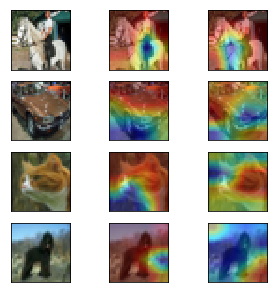

In [42]:
in_img1, sup_img1 = gradCam(preds[56],test_features[56:57],model,"conv2d_12")
in_img2, sup_img2 = gradCam(preds[2000],test_features[2000:2001],model,"conv2d_12")
in_img3, sup_img3 = gradCam(preds[91],test_features[91:92],model,"conv2d_12")
in_img4, sup_img4 = gradCam(preds[85],test_features[85:86],model,"conv2d_12")

in_imgc1, sup_imgc1 = gradCam(predsNew[56],test_features[56:57],modelNew,"conv2d_12")
in_imgc2, sup_imgc2 = gradCam(predsNew[2000],test_features[2000:2001],modelNew,"conv2d_12")
in_imgc3, sup_imgc3 = gradCam(predsNew[91],test_features[91:92],modelNew,"conv2d_12")
in_imgc4, sup_imgc4 = gradCam(predsNew[85],test_features[85:86],modelNew,"conv2d_12")
 
fig = plt.figure(figsize=(5,5))

fig.add_subplot(4, 3, 1, xticks=[], yticks=[])
plt.imshow(in_img1)

fig.add_subplot(4, 3, 2, xticks=[], yticks=[])
plt.imshow(sup_img1)

fig.add_subplot(4, 3, 3, xticks=[], yticks=[])
plt.imshow(sup_imgc1)

fig.add_subplot(4, 3, 4, xticks=[], yticks=[])
plt.imshow(in_img2)

fig.add_subplot(4, 3, 5, xticks=[], yticks=[])
plt.imshow(sup_img2)

fig.add_subplot(4, 3, 6, xticks=[], yticks=[])
plt.imshow(sup_imgc2)


fig.add_subplot(4, 3, 7, xticks=[], yticks=[])
plt.imshow(in_img3)

fig.add_subplot(4, 3, 8, xticks=[], yticks=[])
plt.imshow(sup_img3)

fig.add_subplot(4, 3, 9, xticks=[], yticks=[])
plt.imshow(sup_imgc3)


fig.add_subplot(4, 3, 10, xticks=[], yticks=[])
plt.imshow(in_img4)

fig.add_subplot(4, 3, 11, xticks=[], yticks=[])
plt.imshow(sup_img4)

fig.add_subplot(4, 3, 12, xticks=[], yticks=[])
plt.imshow(sup_imgc4)


plt.show()
